In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import get_cmap
import seaborn as sns
import string
import pickle # save data frame (results) in a .pkl file
import pandas as pd
import datetime
import os, sys


from scipy.linalg import eigh
import scipy

sys.path.insert(0, 'C:/Users/ragna/Documents/Ragnar/Code/MMDGraph')
import covariance
#reload(readfoldertopanda)
import importlib
importlib.reload(sys.modules['covariance'])


<module 'covariance' from 'C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\\covariance.py'>

# PCA test

Let's test pca projection. 

[9.81918603 0.09153452]
[5.45920158 1.78528098]
[5.45920158 1.78528098]
0.0


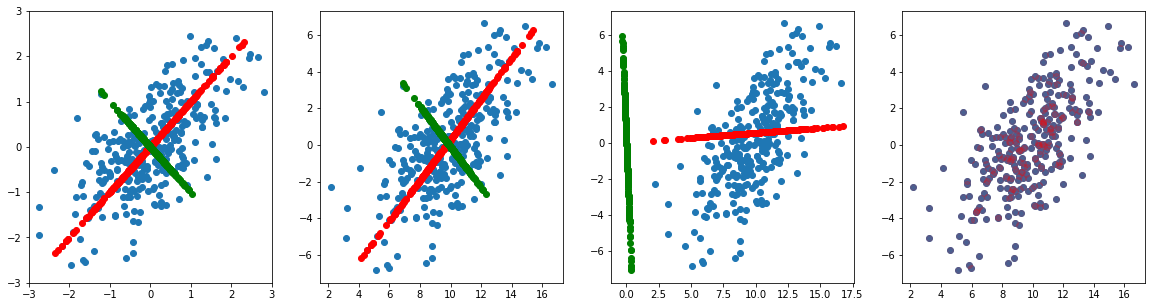

In [158]:
from sklearn.preprocessing import StandardScaler
x = np.random.multivariate_normal([10,0], [[6,4],[4, 6]], 300)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# PCA
u, s, v_t = np.linalg.svd(x_scaled)
u, s, v_1t = np.linalg.svd(x)

print(scaler.mean_)

v_1 = v_t.T[:, 0].reshape((v_t.T.shape[0], 1))
projection_first_scaled = np.dot(x_scaled, v_1).dot(v_1.T) #*scaler.scale_ + scaler.mean_

v_2 = v_t.T[:, 1].reshape((v_t.T.shape[0], 1))
projection_second_scaled = np.dot(x_scaled, v_2).dot(v_2.T) #*scaler.scale_ + scaler.mean_

v_1 = v_t.T[:, 0].reshape((v_t.T.shape[0], 1))
projection_first = np.dot(x_scaled, v_1).dot(v_1.T) *scaler.scale_ + scaler.mean_

v_2 = v_t.T[:, 1].reshape((v_t.T.shape[0], 1))
projection_second = np.dot(x_scaled, v_2).dot(v_2.T) *scaler.scale_ + scaler.mean_

v_1 = v_1t.T[:, 0].reshape((v_1t.T.shape[0], 1))
projection_first_1 = np.dot(x, v_1).dot(v_1.T) 

v_2 = v_1t.T[:, 1].reshape((v_1t.T.shape[0], 1))
projection_second_2 = np.dot(x, v_2).dot(v_2.T) 


projection_all = np.dot(x, v_t.T)
projection_all = np.dot(projection_all, v_t)
# print(np.dot(v_t.T, v_t))

fig, ax = plt.subplots(1,4, figsize = (20,5))

ax[0].scatter(x_scaled[:,0], x_scaled[:,1])
ax[0].scatter(projection_first_scaled[:,0], projection_first_scaled[:,1], color = 'red')
ax[0].scatter(projection_second_scaled[:,0], projection_second_scaled[:,1], color = 'green')
ax[0].set(ylim=(-3, 3), xlim=(-3, 3))
#ax[1].set_aspect('equal', 'box')


ax[1].scatter(x[:,0], x[:,1])
ax[1].scatter(projection_first[:,0], projection_first[:,1], color = 'red')
ax[1].scatter(projection_second[:,0], projection_second[:,1], color = 'green')
# ax[1].set(ylim=(-10, 10), xlim=(90, 110))
# ax[1].set_aspect('equal')

ax[2].scatter(x[:,0], x[:,1])
ax[2].scatter(projection_first_1[:,0], projection_first_1[:,1], color = 'red')
ax[2].scatter(projection_second_2[:,0], projection_second_2[:,1], color = 'green')


ax[3].scatter(x[:,0], x[:,1])
ax[3].scatter(projection_all[:,0], projection_all[:,1], color = 'red', alpha = 0.2)

print(projection_all[3,:])
print(x[3,:])
print(np.dot(projection_first_scaled[30,:], projection_second_scaled[30,:]))

In [66]:
cov = np.cov(x.T)
_, v = np.linalg.eigh(cov)
cov

array([[7.05251358, 4.50692305],
       [4.50692305, 5.73044341]])

In [167]:
u, s, vt = np.linalg.svd(x_scaled)
vt.T

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [171]:
u, s = np.linalg.eigh(np.corrcoef(x.T))
s

array([[-0.70710678,  0.70710678],
       [ 0.70710678,  0.70710678]])

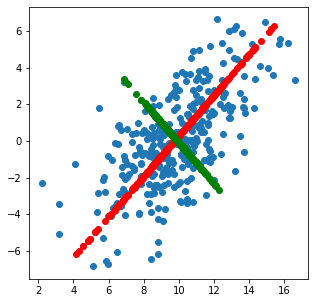

In [173]:
importlib.reload(sys.modules['covariance'])
first = covariance.pca_projection(x, axis= np.array([0]), scale='empirical_correlation')
second = covariance.pca_projection(x, axis= np.array([1]), scale='empirical_correlation')
fig, ax = plt.subplots(1,1, figsize = (5,5))
ax.scatter(x[:,0], x[:,1])
ax.scatter(first[:,0], first[:,1], color = 'red')
ax.scatter(second[:,0], second[:,1], color = 'green')

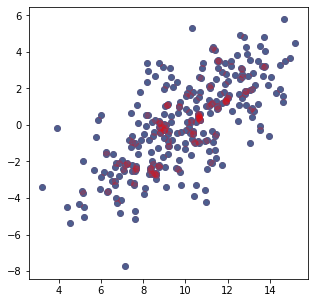

In [ ]:
importlib.reload(sys.modules['covariance'])
first = covariance.pca_projection(x, axis= np.array([0,1]), scale=False)
fig, ax = plt.subplots(1,1, figsize = (5,5))
ax.scatter(x[:,0], x[:,1])
ax.scatter(first[:,0], first[:,1], color = 'red', alpha= 0.2)

# Data Munging

In [93]:
min_date = '2004-01-01 04:00:00'
asset_profiles = pd.read_excel("../Yahoo/YAHOO_PRICE_ESG.xlsx", sheet_name= 'asset_profiles') 
price_data = pd.read_csv("../Yahoo/YAHOO_PRICE.csv")

price_data['timestamp'] = pd.to_datetime(price_data['timestamp'])
price_filtered = price_data.loc[price_data['timestamp'] > min_date, price_data.columns]
price_filtered['date'] = price_filtered['timestamp'].dt.date

price_filtered['return'] = price_filtered.sort_values('date').groupby(['ticker']).adjclose.pct_change()


price_pivot = price_filtered[['ticker', 'return', 'date']].copy()
price_pivot['return'] = np.log(1 + price_pivot['return'])
price_pivot = price_pivot.dropna()  # Drop rows which contain missing values
price_pivot = pd.pivot_table(price_pivot, values = 'return', index = 'date', columns= 'ticker')
price_pivot.shape

# Let's order the columns by sector
company_df = pd.DataFrame({'ticker': np.array(price_pivot.columns)})
company_df = pd.merge(company_df, asset_profiles, on='ticker', how = 'left')
company_df['track_index'] = np.array(range(company_df.shape[0]))
company_df = company_df.sort_values(by = 'sector')
price_pivot = price_pivot.iloc[:, company_df['track_index']]



In [78]:
# Create dictionary to store which company belongs to which sector
sector_classification = dict()
for i in range(asset_profiles.shape[0]):
    if asset_profiles['sector'].iloc[i] not in sector_classification.keys():
        sector_classification[asset_profiles['sector'].iloc[i]] = list()
    sector_classification[asset_profiles['sector'].iloc[i]].append(asset_profiles['ticker'].iloc[i])


In [86]:
price_pivot.loc[:, sector_classification['Industrials']]

ticker,MMM,ALK,ALLE,AAL,AME,AOS,ADP,AVY,BA,CHRW,...,TT,TDG,UNP,UAL,UPS,URI,VRSK,WAB,WM,XYL
date,,,,,,,,,,,,,,,,,,,,,
2004-01-05,0.018892,-0.002161,NaN,NaN,0.021428,0.006785,0.029102,0.035486,0.001903,0.021647,...,0.011717,NaN,0.002890,NaN,0.003794,-0.008048,NaN,0.008202,-0.013500,NaN
2004-01-06,-0.003065,0.043730,NaN,NaN,-0.009646,-0.010480,0.009436,-0.002073,-0.003333,0.005660,...,-0.019655,NaN,-0.011759,NaN,-0.006105,0.012048,NaN,-0.006438,-0.011620,NaN
2004-01-07,-0.017388,-0.014949,NaN,NaN,0.005839,-0.005997,-0.005312,0.006550,0.008312,-0.018383,...,0.016701,NaN,-0.019911,NaN,-0.003272,0.009931,NaN,-0.005299,-0.008978,NaN
2004-01-08,-0.006750,-0.008795,NaN,NaN,0.001805,-0.003156,-0.001938,-0.006897,0.013625,0.000784,...,0.004868,NaN,-0.000745,NaN,-0.008226,0.017630,NaN,0.003536,-0.006612,NaN
2004-01-09,-0.003392,-0.022513,NaN,NaN,0.002002,-0.017392,-0.023063,-0.017453,-0.005146,-0.013670,...,-0.023376,NaN,-0.008233,NaN,-0.010517,-0.017136,NaN,0.011696,-0.007008,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-14,0.017623,0.008380,0.026333,0.001529,0.032538,0.024976,0.016099,0.011182,-0.019763,0.026427,...,0.025688,0.005916,0.025116,0.000626,0.039208,0.037270,0.015146,0.018058,0.019110,0.028196
2021-10-15,0.008944,0.004337,0.013060,0.017163,-0.000390,0.006566,0.021163,0.009677,-0.001841,0.007318,...,-0.006131,0.005850,0.017111,0.001877,0.012099,-0.008551,-0.004358,0.010050,0.001329,0.010643
2021-10-18,-0.001210,-0.006077,0.005429,-0.007032,0.004975,-0.001371,-0.001927,-0.001097,-0.000276,0.025046,...,0.009495,0.000813,0.003414,-0.017443,-0.001860,0.002659,0.001945,-0.008953,-0.006406,0.003203


In [4]:
test_data = price_pivot.iloc[4380:]
test_data.isnull().sum()[test_data.isnull().sum() >0]

Series([], dtype: int64)

# Empirical covariance on Test Data

In [379]:
cov_normal = test_data.cov()
corr_normal = covariance.corrMat(np.array(cov_normal))

<AxesSubplot:>

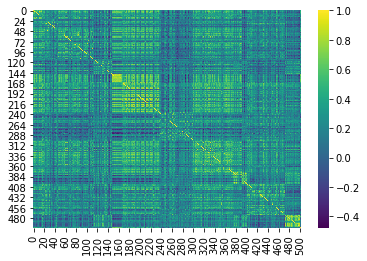

In [380]:
sns.heatmap(corr_normal, cmap = 'viridis')

In [351]:
list(range(1,10))

[1, 2, 3, 4, 5, 6, 7, 8, 9]

<AxesSubplot:>

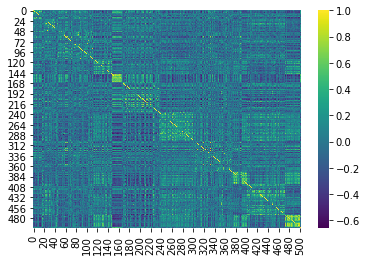

In [390]:
#  + list(range(10,test_data.shape[1]))
data_no_market_normal = covariance.subtract_projection(np.array(test_data), axis= np.array([0]))
corr_no_market_normal = np.corrcoef(data_no_market_normal.T)
sns.heatmap(corr_no_market_normal, cmap = 'viridis')

Let's check the two companies with the minimum correlation, after filtering out the market effect. 

In [391]:
print(corr_no_market_normal.min().min())
np.where(corr_no_market_normal == corr_no_market_normal.min().min())


-0.6577058258761034


(array([199, 210], dtype=int64), array([210, 199], dtype=int64))

In [394]:
print(test_data.columns[199])
print(test_data.columns[210])


MCO
RF


In [395]:
print(np.corrcoef(data_no_market_normal[:,199], data_no_market_normal[:,210]))

[[ 1.         -0.65770583]
 [-0.65770583  1.        ]]


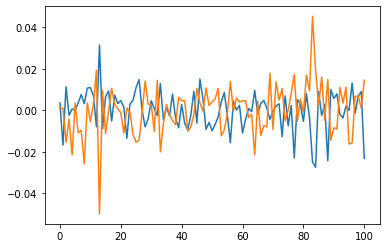

In [396]:
plt.plot(range(test_data.shape[0]),data_no_market_normal[:,199])
plt.plot(range(test_data.shape[0]),data_no_market_normal[:,210])

Compared to the empirical data

In [397]:
print(np.corrcoef(test_data['MCO'], test_data['RF']))

[[1.         0.00153004]
 [0.00153004 1.        ]]


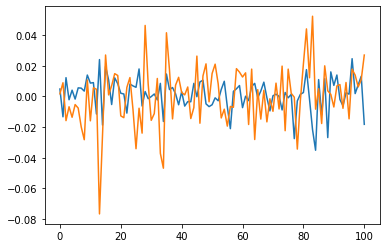

In [398]:
plt.plot(range(test_data.shape[0]),test_data['MCO'])
plt.plot(range(test_data.shape[0]),test_data['RF'])

In [402]:
asset_profiles.loc[(asset_profiles['ticker'].isin(['MCO', 'RF']))]

,Unnamed: 0,address,city,state,zip,country,industry,sector,boardRisk,compensationRisk,shareHolderRightsRisk,overallRisk,ticker
324,0,7 World Trade Center,New York,NY,10007,United States,Financial Data & Stock Exchanges,Financial Services,6.0,7.0,4.0,5.0,MCO
398,0,1900 Fifth Avenue North,Birmingham,AL,35203,United States,Banks—Regional,Financial Services,3.0,9.0,8.0,7.0,RF


# MCD on Test Data

c:\Users\ragna\Documents\Ragnar\Code\MMDGraph\.venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:647: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


<AxesSubplot:>

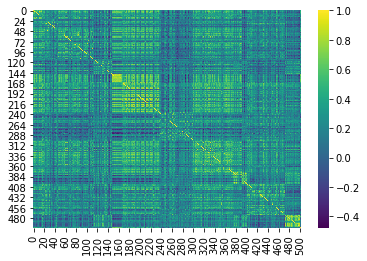

In [342]:
from sklearn.covariance import MinCovDet
cov_mcd = MinCovDet().fit(test_data).covariance_
corr_mcd = corrMat(cov_mcd)
sns.heatmap(corr_mcd, cmap = 'viridis')

<AxesSubplot:>

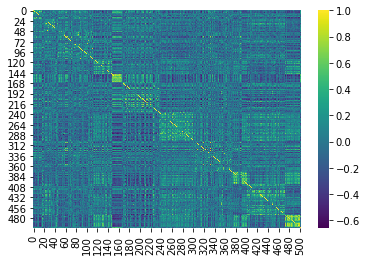

In [360]:
 # + list(range(10,test_data.shape[1]))
importlib.reload(sys.modules['covariance'])
data_no_market_mcd = covariance.subtract_projection(np.array(test_data), cov =cov_mcd,  axis= np.array([0]), scale = 'robust_correlation')
corr_no_market_mcd = np.corrcoef(data_no_market_mcd.T)
sns.heatmap(corr_no_market_mcd, cmap = 'viridis')

# S- estimator

In [90]:
y_mean = np.array([10,0])
y_cov = np.array([[6,4],[4, 6]])
y = np.random.multivariate_normal(y_mean, y_cov, 700)
np.dot((y-y_mean).T, (y-y_mean) * y[0,:])#.shape

array([[36375.99352119,  -759.72171245],
       [25395.59118266, -1128.44996244]])

In [5]:
importlib.reload(sys.modules['covariance'])
covariance.S_estimation_cov(y, initial='K', maxsteps=5, propmin=0.1, qs=2, maxit=200, tol=1e-4, corr=False)

NameError: name 'y' is not defined

In [73]:
covariance.mahalanobis_distance(np.array(test_data), muini, Vini_inv)

array([  316.54029017,   -92.70198701,   -88.48873608,   651.19406563,
         179.63079607,   263.03309854,  -130.74475989,    99.94124883,
         418.69695186,   573.6671742 ,   -81.96424222,   317.18465452,
         197.63559727,    22.44512981,  -190.63123605,   649.32589691,
         235.21702881,   160.34323531,   176.98138466,  -123.60547732,
        -178.6412447 ,  -140.58484322,    34.59662472,   259.90999152,
         117.01629381,   295.92823908,  -118.91970419,   459.63695756,
          19.55853227,   475.76129796,   525.15198736,  -261.45964444,
         203.35139465,   221.30286339,   112.0447932 ,   109.79273843,
          65.02687606,   156.92878882,    36.86121586,  -376.71453885,
         264.55396562,  -465.43419221,   193.62456572,   198.2094047 ,
        -269.3132868 ,   517.78681864,   859.09121829, -1014.3114098 ,
         116.95745601,    91.97087232,   290.76196517,  -159.71096337,
          53.29364725,    49.1778908 ,    63.06509435,   111.78905014,
      

In [88]:
importlib.reload(sys.modules['covariance'])
covariance.svd_trunc_mahalanobis_distance(np.array(test_data), muini, Vini, 0.99)

array([80.2703789 , 97.76524094, 93.72497774, 89.2384797 , 80.57342281,
       97.64377049, 91.17584388, 93.8690728 , 91.95420736, 91.49602777,
       79.14560592, 81.13547702, 90.42896907, 89.04397657, 93.55222648,
       62.42790971, 77.59469787, 64.03487797, 89.43266822, 93.90521091,
       91.8918349 , 89.22841679, 88.76380825, 80.67717901, 50.91806459,
       84.08469016, 67.86261467, 75.02622929, 53.40332316, 76.27561918,
       87.45795252, 76.98288623, 92.55056801, 89.14717656, 89.39769034,
       96.10493574, 95.93476167, 97.42574449, 91.90820546, 95.75987481,
       97.2969397 , 97.44192676, 98.06098849, 96.89262191, 94.20065561,
       97.96574642, 96.66309526, 98.23603099, 95.61426018, 94.62344988,
       94.16045769, 93.96931216, 85.36094652, 82.20517439, 75.85052137,
       90.09465877, 93.54070242, 95.6274248 , 71.97329194, 85.08906377,
       88.34667705, 83.66805229, 86.56935447, 72.34343918, 59.18487374,
       90.23875698, 95.37278645, 95.9780636 , 54.68420882, 94.68

In [26]:
np.linalg.cond(Vini +  0.0002 * np.identity(Vini.shape[0]))

208.79920448473314

In [55]:
u,s, vt = np.linalg.svd(A)
s

array([4.15598409e-02, 1.18050653e-02, 6.84841277e-03, 4.31017414e-03,
       3.61042207e-03, 2.99568889e-03, 2.39926140e-03, 2.20276126e-03,
       1.99879721e-03, 1.77920245e-03, 1.75121619e-03, 1.65707163e-03,
       1.62490232e-03, 1.51604283e-03, 1.46013820e-03, 1.41541084e-03,
       1.29365877e-03, 1.22136507e-03, 1.18555239e-03, 1.15284827e-03,
       1.11075859e-03, 1.06096758e-03, 1.00673744e-03, 9.87636810e-04,
       9.53449174e-04, 9.42526490e-04, 8.99943737e-04, 8.71601211e-04,
       8.38981465e-04, 8.08227596e-04, 7.92749325e-04, 7.78755149e-04,
       7.59872187e-04, 7.20475031e-04, 7.08882099e-04, 6.77267860e-04,
       6.67996475e-04, 6.47090044e-04, 6.32261489e-04, 6.17523673e-04,
       5.83243111e-04, 5.75891858e-04, 5.54607486e-04, 5.44414766e-04,
       5.26066559e-04, 5.21627936e-04, 5.17836481e-04, 4.98858073e-04,
       4.86186688e-04, 4.76637251e-04, 4.73646965e-04, 4.55695467e-04,
       4.49219711e-04, 4.48514737e-04, 4.29862844e-04, 4.15496292e-04,
      

In [62]:
importlib.reload(sys.modules['covariance'])
mu, V, dist = covariance.S_estimation_cov(np.array(test_data), initial='K', maxsteps=5, propmin=0.01, qs=2, maxit=200, tol=1e-4, corr=False)
V_corr = covariance.corrMat(V)

<AxesSubplot:>

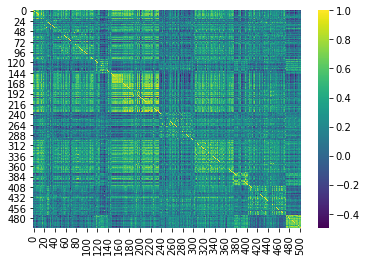

In [63]:
sns.heatmap(V_corr, cmap = 'viridis')

# Regression

In [25]:
def get_index(tick):
    """
    Function that takes the sp500 index from yahoo
    """
    import requests
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
    # ESG historical data (only changes yearly)
    url_esg = f"https://query1.finance.yahoo.com/v7/finance/spark?symbols={tick}&range=10y&interval=1d&indicators=close&includeTimestamps=false&includePrePost=false&corsDomain=finance.yahoo.com&.tsrc=finance"
    response = requests.get(url_esg, headers=headers)
    if response.ok:
        sp500 = pd.DataFrame({'date':pd.to_datetime(response.json()['spark']['result'][0]['response'][0]['timestamp'], unit= 's'),
                              'price':response.json()['spark']['result'][0]['response'][0]['indicators']['quote'][0]['close']})
    
    else:
        print("Empty data frame")
        sp500 = pd.DataFrame()



    return sp500

In [26]:
sp500 = get_index('^GSPC')
sp500['date'] = pd.to_datetime(sp500['date']).dt.date
sp500['return'] = 1 + sp500['price'].pct_change()
sp500['log_return'] = np.log(sp500['price']).diff()
sp500 = sp500.iloc[:,:].dropna(axis= 0)
sp500

,date,price,return,log_return
1,2011-11-01,1218.28,0.972058,-0.028340
2,2011-11-02,1237.90,1.016105,0.015976
3,2011-11-03,1261.15,1.018782,0.018608
4,2011-11-04,1253.23,0.993720,-0.006300
5,2011-11-07,1261.12,1.006296,0.006276
...,...,...,...,...
2512,2021-10-25,4566.48,1.004748,0.004737
2513,2021-10-26,4574.79,1.001820,0.001818
2514,2021-10-27,4551.68,0.994948,-0.005064
2515,2021-10-28,4596.42,1.009829,0.009781


In [34]:
import statsmodels.api as sm


returns_with_index = pd.merge(test_data, sp500, how = 'left', left_index= True, right_on= 'date')
returns_with_index


,NUE,MOS,FMC,VMC,NEM,IFF,FCX,ALB,LYB,MLM,...,ED,EIX,LNT,PEG,WEC,ETR,date,price,return,log_return
2409,0.014637,0.004159,0.003864,-0.011983,0.005322,-0.008225,0.003048,-0.008819,-0.008312,-0.017906,...,0.004802,0.008087,0.007024,0.001450,0.005981,0.004380,2021-05-28,4204.11,1.000769,0.000769
2410,0.076932,0.038273,0.013787,0.001635,0.006376,0.004507,0.034284,0.025702,0.037043,0.000110,...,-0.010542,-0.004485,-0.002804,-0.001450,-0.010060,-0.006003,2021-06-01,4202.04,0.999508,-0.000492
2411,-0.052939,-0.004681,-0.005169,-0.017193,-0.009582,0.009511,-0.019875,-0.006261,-0.008593,-0.018902,...,0.004699,0.008415,0.010647,-0.005821,0.002256,0.000478,2021-06-02,4208.12,1.001447,0.001446
2412,0.019237,0.002410,0.001274,0.013756,-0.022817,-0.006704,-0.034506,-0.012938,0.017029,0.007481,...,0.006102,0.002493,0.009159,0.000648,0.006952,0.010737,2021-06-03,4192.85,0.996371,-0.003635
2413,0.015845,-0.036774,0.004234,-0.018699,0.005473,0.002030,-0.003349,0.031433,-0.004551,-0.021904,...,-0.000259,0.004259,-0.000344,-0.007156,-0.002561,0.001039,2021-06-04,4229.89,1.008834,0.008795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2505,0.008831,0.016074,0.034795,0.033456,0.024533,0.027131,0.038015,0.033718,0.021069,0.040133,...,-0.005009,0.003185,0.012187,0.020399,0.010286,0.008930,2021-10-14,4438.26,1.017063,0.016919
2506,0.005418,0.001931,0.010001,0.003680,-0.012892,-0.005002,0.039863,-0.011128,0.007800,0.006886,...,-0.015985,0.013164,-0.006612,0.011334,0.001889,-0.011958,2021-10-15,4471.37,1.007460,0.007432
2507,0.007342,0.009599,-0.004336,0.020198,-0.011463,-0.014057,-0.002591,0.034963,-0.006885,0.021903,...,-0.021445,-0.003318,-0.007921,-0.006137,-0.013750,-0.004705,2021-10-18,4486.46,1.003375,0.003369
2508,0.007482,-0.001195,0.001411,-0.003718,0.010761,0.010187,0.008011,-0.004060,0.001929,-0.008893,...,0.011458,0.006278,0.006126,0.011596,0.011416,0.002846,2021-10-19,4519.63,1.007393,0.007366


In [224]:
tick = 'ALB'
covariates = pd.DataFrame({'market': returns_with_index.loc[:,'return']})
covariates['const'] = 1


model = sm.OLS(np.exp(returns_with_index[tick]), covariates)
results = model.fit()

model_robust = sm.QuantReg(np.exp(returns_with_index[tick]), covariates)
results_robust = model_robust.fit(q = 0.5)

print(results.params)

print(results_robust.params)

market    1.796465
const    -0.794282
dtype: float64
market    1.622798
const    -0.619469
dtype: float64


(0.0, 1.15)

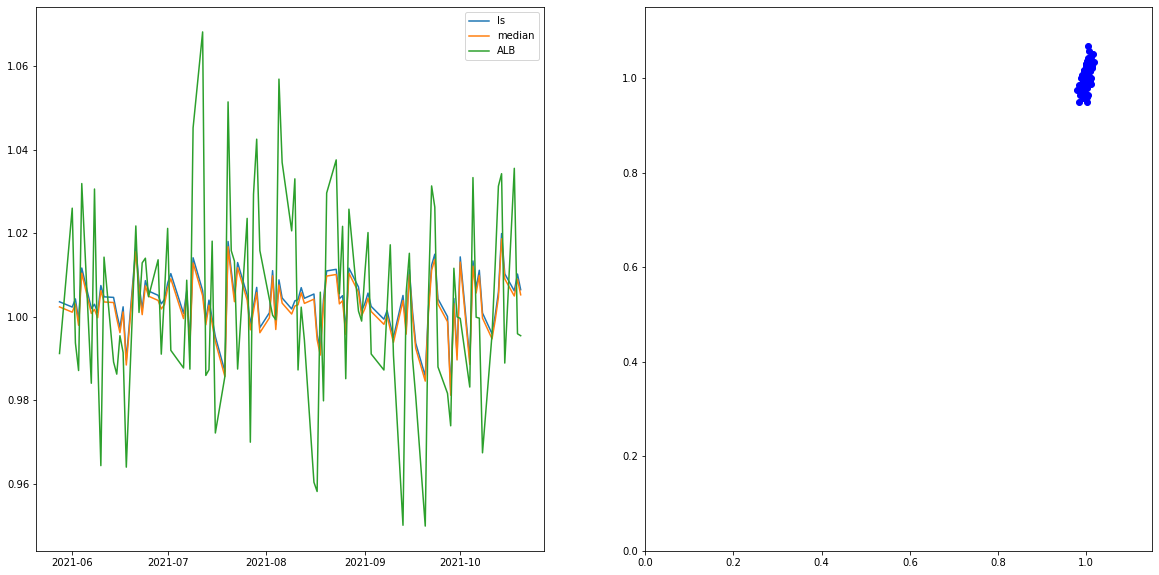

In [223]:
y_hat = model.predict(results.params)
y_hat_rob = model_robust.predict(results_robust.params)

fig, ax = plt.subplots(1,2, figsize = (20,10))
ax[0].plot(returns_with_index['date'], y_hat, label = 'ls')
ax[0].plot(returns_with_index['date'], y_hat_rob, label = 'median')
ax[0].plot(returns_with_index['date'], np.exp(returns_with_index[tick]), label = tick)
ax[0].legend()

ax[1].scatter(covariates['market'], np.exp(returns_with_index[tick]), color = 'b')
ax[1].set_ylim([0, 1.15])
ax[1].set_xlim([0, 1.15])
# ax[1].scatter(covariates['market'], y_hat, color = 'orange')

# All-in-one function

In [13]:
importlib.reload(sys.modules['covariance'])
Vini = np.cov(test_data.T)
muini = np.mean(test_data)
Vini_inv = np.linalg.inv(Vini)
mu, V, dist = covariance.S_estimation_cov(np.array(test_data), initial='K', maxsteps=5, propmin=0.01, qs=2, maxit=200, tol=1e-4, corr=False)

In [30]:
market_effect = sp500.loc[sp500['date'] >= np.min(test_data.index)]
market_effect.shape[0] == test_data.shape[0]

False

In [32]:
test_data.shape[0]

101

In [21]:
importlib.reload(sys.modules['covariance'])
x_no_market_pca = covariance.remove_effect(np.array(test_data), effect_type = 'pca')
x_no_market_rob_pca = covariance.remove_effect(np.array(test_data), effect_type = 'rob_pca', cov = V)

In [55]:
returns_with_index = pd.merge(test_data, sp500, how = 'left', left_index= True, right_on= 'date')

In [187]:
importlib.reload(sys.modules['covariance'])
x_no_market_reg = covariance.remove_effect(np.array(test_data), effect_type = 'reg', market_return= returns_with_index['return'])
x_no_market_rob_reg = covariance.remove_effect(np.array(test_data), effect_type = 'rob_reg', market_return= returns_with_index['return'])

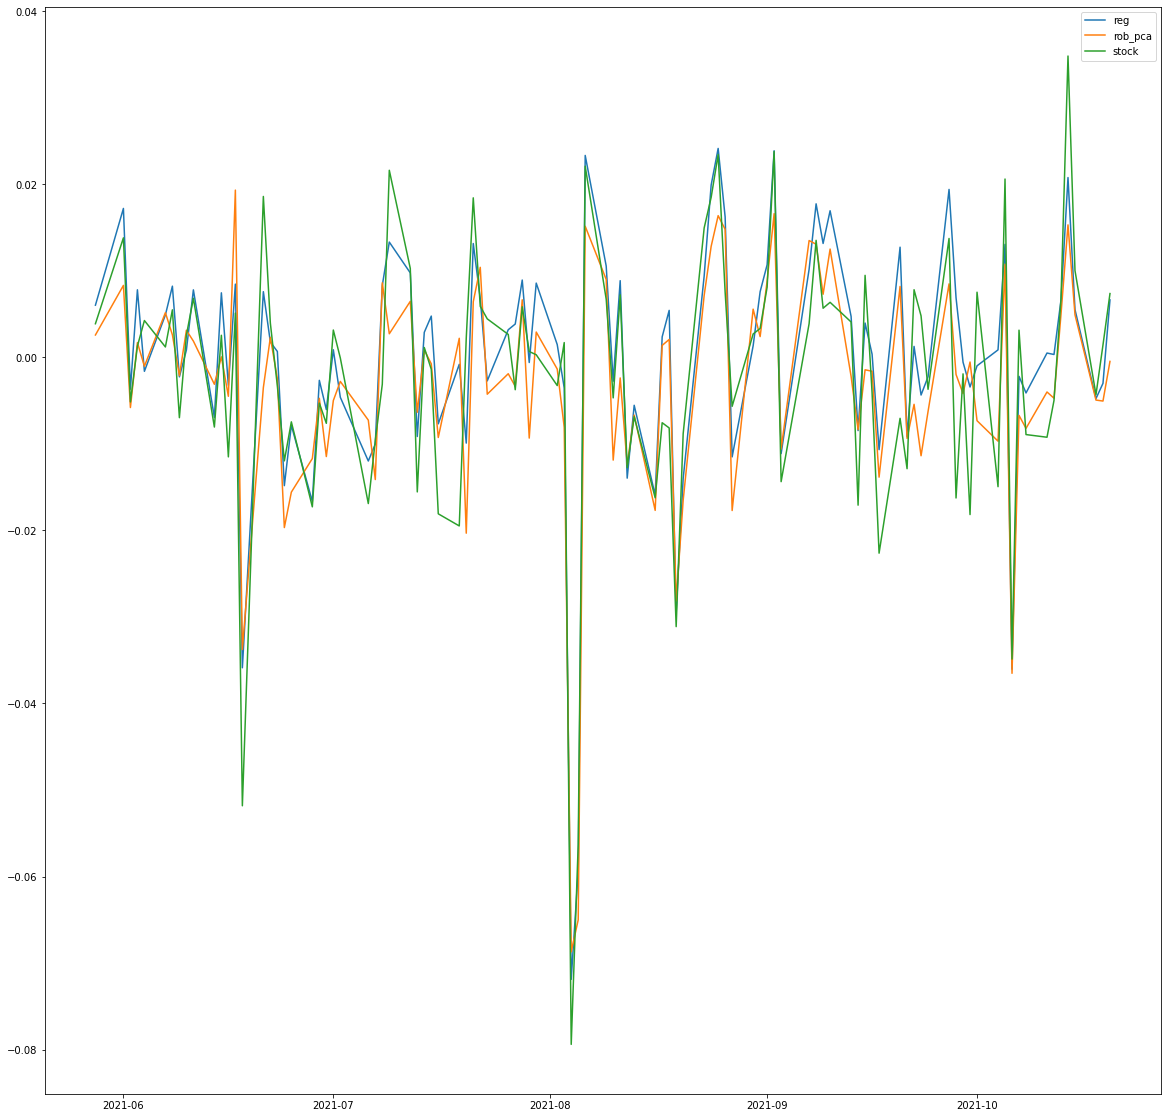

In [188]:
fig, ax = plt.subplots(1,1, figsize = (20, 20))

idx = 2
ax.plot(list(test_data.index), x_no_market_reg[:,idx], label = 'reg')
#ax.plot(list(test_data.index), x_no_market_rob_reg[:,idx], label = 'rob_reg')
#ax.plot(list(test_data.index), x_no_market_pca[:,idx], label = 'pca')
ax.plot(list(test_data.index), x_no_market_rob_pca[:,idx], label = 'rob_pca')
ax.plot(list(test_data.index), test_data.iloc[:,idx], label = 'stock')
ax.legend()


In [186]:
np.sum(np.isnan(x_no_market_rob_reg))

25392

# Covariance Time series

In [200]:
#[datetime.datetime.strptime(s, '%y-%d-%m') for s in price_pivot.index ]
test_data_series = price_pivot.loc[price_pivot.index > datetime.datetime.strptime('2012-01-01', '%Y-%d-%m').date()]
test_data_series_no_na = test_data_series.dropna(axis = 0)

In [205]:
what = np.array(range(test_data_series.shape[0]))
what[what[test_data_series.index.isin(test_data_series_no_na.index)]]

array([2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366, 2367,
       2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378,
       2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388, 2389,
       2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400,
       2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411,
       2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422,
       2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432, 2433,
       2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443, 2444,
       2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454, 2455,
       2456, 2457, 2458, 2459, 2460, 2461, 2462, 2463, 2464, 2465, 2466])

In [175]:
returns_with_index_series = pd.merge(test_data_series, sp500, how = 'left', left_index= True, right_on= 'date')
returns_with_index_series

,NUE,MOS,FMC,VMC,NEM,IFF,FCX,ALB,LYB,MLM,...,ED,EIX,LNT,PEG,WEC,ETR,date,price,return,log_return
43,0.023724,0.041939,0.017283,0.008351,0.033913,0.008737,0.071075,0.023408,0.029717,0.004366,...,-0.022499,-0.000966,-0.013466,-0.037030,-0.011797,-0.007282,2012-01-03,1277.06,1.015474,0.015355
44,0.008845,-0.005529,-0.001944,-0.009623,-0.003065,0.001323,0.008320,0.014498,0.037242,-0.000396,...,-0.012443,-0.008254,-0.006686,-0.004726,-0.002898,-0.008586,2012-01-04,1277.30,1.000188,0.000188
45,0.001711,0.018940,-0.004819,0.008110,0.003387,-0.000944,-0.013396,0.001494,-0.014497,0.002375,...,-0.002675,-0.012018,0.009898,0.010682,0.005500,0.000000,2012-01-05,1281.06,1.002944,0.002939
46,0.005358,-0.011890,0.011663,-0.008364,-0.002096,0.003208,-0.011002,-0.002055,0.006114,-0.022656,...,-0.010771,-0.003460,-0.005052,-0.004071,-0.004339,-0.005579,2012-01-06,1277.81,0.997463,-0.002540
47,-0.002188,0.007377,0.000000,0.005331,-0.007938,0.002823,0.004364,-0.000748,-0.003781,0.008990,...,0.002873,-0.000495,-0.002074,-0.007243,0.000290,0.001258,2012-01-09,1280.70,1.002262,0.002259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2505,0.008831,0.016074,0.034795,0.033456,0.024533,0.027131,0.038015,0.033718,0.021069,0.040133,...,-0.005009,0.003185,0.012187,0.020399,0.010286,0.008930,2021-10-14,4438.26,1.017063,0.016919
2506,0.005418,0.001931,0.010001,0.003680,-0.012892,-0.005002,0.039863,-0.011128,0.007800,0.006886,...,-0.015985,0.013164,-0.006612,0.011334,0.001889,-0.011958,2021-10-15,4471.37,1.007460,0.007432
2507,0.007342,0.009599,-0.004336,0.020198,-0.011463,-0.014057,-0.002591,0.034963,-0.006885,0.021903,...,-0.021445,-0.003318,-0.007921,-0.006137,-0.013750,-0.004705,2021-10-18,4486.46,1.003375,0.003369
2508,0.007482,-0.001195,0.001411,-0.003718,0.010761,0.010187,0.008011,-0.004060,0.001929,-0.008893,...,0.011458,0.006278,0.006126,0.011596,0.011416,0.002846,2021-10-19,4519.63,1.007393,0.007366


In [214]:
importlib.reload(sys.modules['covariance'])
covariance_dict, nodes_d, time_index = covariance.construct_covariance(test_data_series, sector_classification, remove_market_type = 'pca', reconstruction_type = 'empirical', step = 30, market_return= np.array(returns_with_index_series['return']))

C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\covariance.py:89: RuntimeWarning: invalid value encountered in double_scalars
  corr_mat[i,j] = cov[i,j] / np.sqrt(cov[i,i] * cov[j,j])
C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\covariance.py:252: UserWarning: nan value in x_no_market
  warnings.warn("nan value in x_no_market")
C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\covariance.py:89: RuntimeWarning: invalid value encountered in double_scalars
  corr_mat[i,j] = cov[i,j] / np.sqrt(cov[i,i] * cov[j,j])
C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\covariance.py:252: UserWarning: nan value in x_no_market
  warnings.warn("nan value in x_no_market")
C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\covariance.py:89: RuntimeWarning: invalid value encountered in double_scalars
  corr_mat[i,j] = cov[i,j] / np.sqrt(cov[i,i] * cov[j,j])
C:/Users/ragna/Documents/Ragnar/Code/MMDGraph\covariance.py:252: UserWarning: nan value in x_no_market
  warnings.warn("nan value in x_no_market")


In [193]:
what = np.array([1,2,3,4])
what[-2:]

array([3, 4])

In [211]:
graphs['Industrials'][0]

array([[ 1.        ,  0.01530659, -0.34737866, ...,  0.0018057 ,
        -0.25663443,  0.0581918 ],
       [ 0.01530659,  1.        , -0.08515884, ...,  0.13119194,
         0.13444809, -0.09289866],
       [-0.34737866, -0.08515884,  1.        , ..., -0.1315612 ,
         0.01799878, -0.33659778],
       ...,
       [ 0.0018057 ,  0.13119194, -0.1315612 , ...,  1.        ,
         0.10181579,  0.27577437],
       [-0.25663443,  0.13444809,  0.01799878, ...,  0.10181579,
         1.        , -0.20422803],
       [ 0.0581918 , -0.09289866, -0.33659778, ...,  0.27577437,
        -0.20422803,  1.        ]])